# Loading of Libraries and Classes.  


In [1]:
%matplotlib inline
from datetime import date
import time
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 60
from Curves.Corporates.CorporateDailyVasicek import CorporateRates
from Boostrappers.CDSBootstrapper.CDSVasicekBootstrapper import BootstrapperCDSLadder
from MonteCarloSimulators.Vasicek.vasicekMCSim import MC_Vasicek_Sim
from Products.Rates.CouponBond import CouponBond
from Products.Credit.CDS import CDS
from Scheduler.Scheduler import Scheduler
import quandl
import matplotlib.pyplot as plt
import pylab
from parameters import WORKING_DIR
import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*'))
from IPython.core.pylabtools import figsize
figsize(15, 4)
from pandas import ExcelWriter
import numpy.random as nprnd
from pprint import pprint

# Create forward bond future PV (Exposure) time profile

# Setting up parameters  


In [8]:
t_step = 1.0 / 365.0
simNumber = 10
trim_start = date(2005,3,10)
trim_end = date(2010,12,31)  # Last Date of the Portfolio
start = date(2005, 3, 10)
referenceDate = date(2005, 3, 10)

# Data input for the CouponBond portfolio
The word portfolio is used to describe just a dict of CouponBonds.

#### This line creates a referenceDateList
myScheduler = Scheduler()

ReferenceDateList = myScheduler.getSchedule(start=referenceDate,end=trim_end,freq="1M", referencedate=referenceDate)
### Create Simulator
#### This section creates Monte Carlo Trajectories in a wide range. Notice that the BondCoupon maturities have to be 
#### inside the Monte Carlo simulation range [trim_start,trim_end]
#### Sigma has been artificially increased (OIS has smaller sigma) to allow for visualization of distinct trajectories. 
        # SDE parameters - Vasicek SDE
        # dr(t) = k(θ − r(t))dt + σdW(t)
        self.kappa = x[0]
        self.theta = x[1]
        self.sigma = x[2]
        self.r0 = x[3]
        
myVasicek = MC_Vasicek_Sim()
xOIS = [ 3.0,  0.07536509, -0.208477,  0.07536509]
myVasicek.setVasicek(x=xOIS,minDay=trim_start,maxDay=trim_end,simNumber=simNumber,t_step=1/365.0)
myVasicek.getLibor()

### Create Coupon Bond with several startDates.
SixMonthDelay = myScheduler.extractDelay("6M")
TwoYearsDelay = myScheduler.extractDelay("2Y")
startDates = [referenceDate + nprnd.randint(0,3)*SixMonthDelay for r in range(10)]

### For debugging uncomment this to choose a single date for the forward bond
### print(startDates)
#startDates = [date(2005,3,10)] # or
#startDates = [date(2005,3,10) + SixMonthDelay]
#maturities = [(x+TwoYearsDelay) for x in startDates]



#### You can change the coupon and see its effect on the Exposure Profile.  The breakevenRate is calculated, for simplicity, always at referenceDate=self.start, that is, at the first day of the CouponBond life.




##### Below is a way to create random long/short bond portfolio of any size.  The notional only affects the product class at the last stage of calculation. In my case, the only parameters affected are Exposure (PV on referenceDate), pvAvg(average PV on referenceDate)

myPortfolio = {}
coupon = 0.07536509
for i in range(len(startDates)):
    notional=(-1.0)**i
    myPortfolio[i] = CouponBond(fee=1.0,start=startDates[i],coupon=coupon,notional=notional,
                                maturity= maturities[i], freq="3M", referencedate=referenceDate)

In [9]:
myScheduler = Scheduler()
ReferenceDateList = myScheduler.getSchedule(start=referenceDate,end=trim_end,freq="1M", referencedate=referenceDate)
# Create Simulator
xOIS = [ 3.0,  0.07536509, -0.208477,  0.07536509]
myVasicek = MC_Vasicek_Sim(ReferenceDateList,xOIS,simNumber,1/365.0)
myVasicek.setVasicek(x=xOIS,minDay=trim_start,maxDay=trim_end,simNumber=simNumber,t_step=1/365.0)
myVasicek.getLibor()

# Create Coupon Bond with several startDates.
SixMonthDelay = myScheduler.extractDelay("6M")
TwoYearsDelay = myScheduler.extractDelay("2Y")
startDates = [referenceDate + nprnd.randint(0,3)*SixMonthDelay for r in range(10)]

# For debugging uncomment this to choose a single date for the forward bond
# print(startDates)
startDates = [date(2005,3,10)+SixMonthDelay,date(2005,3,10)+TwoYearsDelay ]
maturities = [(x+TwoYearsDelay) for x in startDates]

myPortfolio = {}
coupon = 0.07536509
for i in range(len(startDates)):
    notional=(-1.0)**i
    myPortfolio[i] = CouponBond(fee=1.0,start=startDates[i],coupon=coupon,notional=notional,
                                maturity= maturities[i], freq="3M", referencedate=referenceDate,observationdate=trim_start )

# Create Libor and portfolioScheduleOfCF.  This datelist contains all dates 
# to be used in any calculation of the portfolio positions.
# BondCoupon class has to have a method getScheduleComplete, which return
# fullSet on [0] and datelist on [1], calculated by BondCoupon as:

def getScheduleComplete(self):
 self.datelist=self.myScheduler.getSchedule(start=self.start,end=self.maturity,freq=self.freq,referencedate=self.referencedate)
    self.ntimes = len(self.datelist)
    fullset = sorted(set(self.datelist)
                               .union([self.referencedate])
                               .union([self.start])
                               .union([self.maturity])
                               )
    return fullset,self.datelist

# portfolioScheduleOfCF is the concatenation of all fullsets. It defines the set of all dates for which Libor should be known.  


In [10]:
# Create FullDateList
portfolioScheduleOfCF = set(ReferenceDateList)
for i in range(len(myPortfolio)):
    portfolioScheduleOfCF=portfolioScheduleOfCF.union(myPortfolio[i].getScheduleComplete()[0]
)
portfolioScheduleOfCF = sorted(portfolioScheduleOfCF.union(ReferenceDateList))
OIS = myVasicek.getSmallLibor(datelist=portfolioScheduleOfCF)
#print(OIS)
# at this point OIS contains all dates for which the discount curve should be known.
# If the OIS doesn't contain that date, it would not be able to discount the cashflows and the calcualtion would faill.

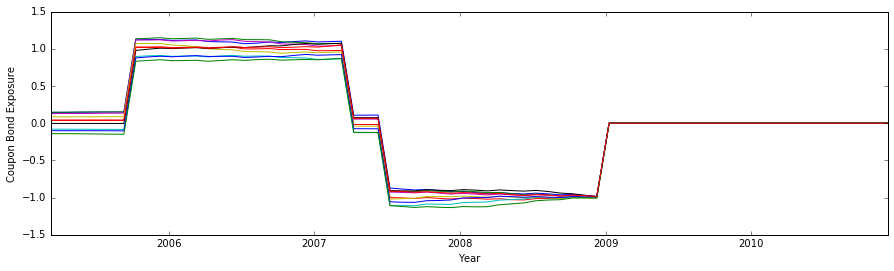

In [11]:
pvs={}
for t in portfolioScheduleOfCF:
    pvs[t] = np.zeros([1,simNumber])
    #(pvs[t])
    for i in range(len(myPortfolio)):
        myPortfolio[i].setLibor(OIS)
        pvs[t] = pvs[t] + myPortfolio[i].getExposure(referencedate=t).values
        # print(myPortfolio[i].getExposure(referencedate=t).values)

#print(pvs)
#print(OIS)
#print(myPortfolio[i].getExposure(referencedate=t).value)

pvsPlot = pd.DataFrame.from_dict(list(pvs.items()))
pvsPlot.index= list(pvs.keys())
pvs1={}
for i,t in zip(pvsPlot.values,pvsPlot.index):
    pvs1[t]=i[1][0]
pvs = pd.DataFrame.from_dict(data=pvs1,orient="index")
ax=pvs.plot(legend=False)
ax.set_xlabel("Year")
ax.set_ylabel("Coupon Bond Exposure")